# Sentiment Analysis

...of all text variables
 I change something to be able to push again

In [11]:
from load_data import *
from helpers import clean_comments
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from langdetect import detect
from deep_translator import GoogleTranslator

from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from textblob import TextBlob


Load and clean the reviews

In [12]:
price, listings, reviews = load_data()

Data loaded.


D:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\load_data.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\load_data.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(country_list[i])
D:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\load_data

Data cleansed.
Imputation done. No NaN's are left in the data.
Further Modifications are done.
Have fun implementing your models.


In [13]:
com_list = reviews["comments"].apply(lambda x: clean_comments(x))

#List of reviews
reviews_f = [r for r in com_list if pd.notnull(r)]

# def det_and_trans(review):
#     if len(review) == 0:
#         return review
#     if not review.islower():
#         return review
#     det_lan = detect(review)
#     check = det_lan == "en"
#     if not check:
#         translation = GoogleTranslator(source='auto', target='en').translate(review)
#         return translation
#
# #started at 17:10
# for i in range(len(reviews_f)):
#     reviews_f[i] = det_and_trans(reviews_f[i])
#     print(i)
#
# are those fine?
#reviews_f = list(map(lambda x: det_and_trans(x), reviews_f))
#reviews_f = pd.DataFrame(reviews_f).apply(lambda x: det_and_trans(x))
#
# reviews_f_df = pd.DataFrame(reviews_f)
# reviews_f_df.to_csv("trans_reviews.csv")

reviews_f_read = pd.read_csv("trans_reviews.csv")
reviews_f_read.columns = ["to_delete", "review"]
del reviews_f_read["to_delete"]

reviews_f_read.loc[reviews_f_read["review"].isnull(), "review"] = com_list[reviews_f_read["review"].isnull()]
reviews_f = reviews_f_read["review"].values.tolist()

Let's look at some word frequencies

In [14]:
# Word Frequency
def convert(lst):
    return ([i for item in lst for i in item.split()])

all_words_review = convert(reviews_f)

count_word = collections.Counter(all_words_review) #Count word frequency
clean_word_count = pd.DataFrame(count_word.most_common(10),
                             columns=['words', 'count'])
clean_word_count.head()

# So let us remove stop words
stop_words = set(stopwords.words(['english']))
# Add some words after analysing
freq_airbnb = ["us", "would", "host", "house", "room", "city", "apartment",
               "location", "dublin", "place", "stay", "de", "also"]
stop_words.update(freq_airbnb)


# View a few words from the set
list(stop_words)[0:10]

['ours',
 'from',
 'house',
 'against',
 'myself',
 'we',
 'their',
 'have',
 "you're",
 'won']

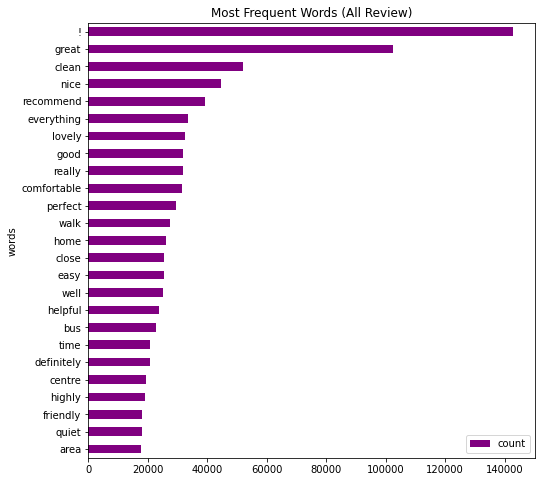

In [15]:
words_review_cleaned = [word for word in all_words_review if word not in stop_words]
words_review_count = collections.Counter(words_review_cleaned)

word_review_count_df = pd.DataFrame(words_review_count.most_common(25),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
word_review_count_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words (All Review)")

plt.show()

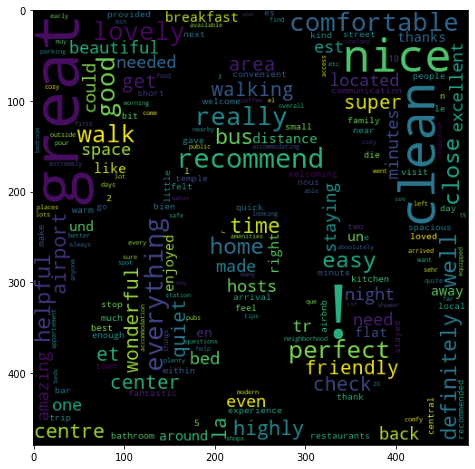

In [16]:
mask = np.array(Image.open("AirBnB_Logo.png"))

wordcloud = WordCloud(width = 1000, height = 500, mask = mask, #background_color="white",
                      ).generate_from_frequencies(words_review_count)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

Now Perform the Sentiment Analysis with NLTK

Neutral, Negativity and Positivity sum up to 1 (like how much of what is in it)
Compound is a weighted normalized (-1,1) score of the sum of the valence -> Sentiment of entire text.

In [17]:

# "no problem(s)" and "no complaints" only was quite negative and special cases do not validate on their own
def no_prob_to_good(review, term):
    if term in review:
        if len(review.split()) < 5:
            review = "We did not have any problems."
    return review
term = "no problem"

for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)

term = "no complaint"

for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)


# Polarity Scores
sid = SentimentIntensityAnalyzer()
#sid.constants.SPECIAL_CASE_IDIOMS.update({"no problem" : 1.5, "no problems" : 1.5}) # "no problem(s)" was very negative
pscores = [sid.polarity_scores(comment) for comment in reviews_f]

Histograms of different Polarity Scores

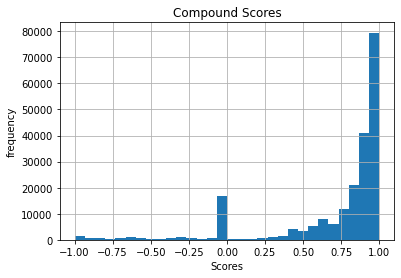

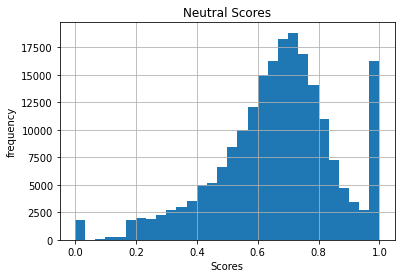

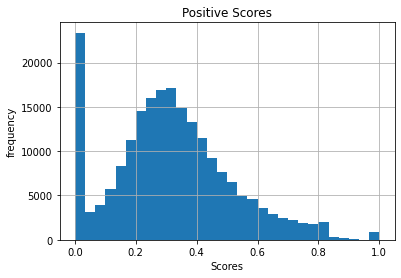

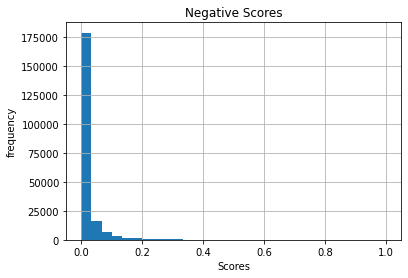

In [18]:
#Histogram plot neutral
pd.Series([score['compound'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot neutral
pd.Series([score['neu'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Neutral Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot positive
pd.Series([score['pos'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot negative
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

Create a useful dataframe

In [19]:
#Create dataframe for sentiment analysis
scored_reviews = pd.DataFrame()
scored_reviews["listing_id"] = reviews["listing_id"]
scored_reviews['review'] = [r for r in reviews_f]
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

worst_reviews = scored_reviews[scored_reviews["negativity"] > 0.7]
worst_reviews["review"]

In [ ]:
worst_reviews2 = scored_reviews[scored_reviews["compound"] < -0.97]
worst_reviews2["review"]
worst_reviews2.loc[57642]["review"]

In [ ]:
best_reviews = scored_reviews[scored_reviews["compound"] > 0.99]
best_reviews["review"]

Easy package TextBlob

TextBlob:
Polarity is Positivity minus Negativity.
Subjectivity describes how subjective the review is.
Maybe very subjective reviews (subjectivity closer to 1) are not as seen as representative.
To adjust for this, correct the polarity by turning around the subjectivity score to then
multiply it with the polarity.

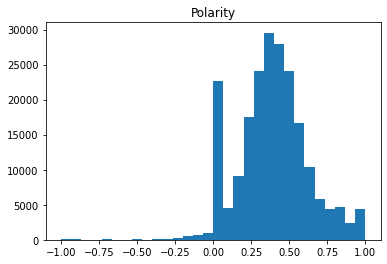

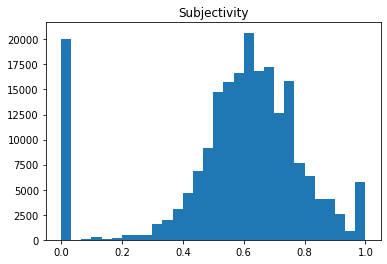

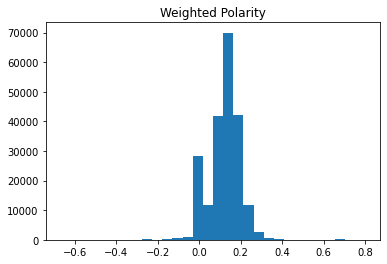

In [20]:
comments_clnd = pd.DataFrame(reviews_f)
comments_clnd.columns = ["clnd_reviews"]
comments_pol = comments_clnd["clnd_reviews"].apply(lambda x: TextBlob(x).sentiment[0])
comments_subj = comments_clnd["clnd_reviews"].apply(lambda x: TextBlob(x).sentiment[1])

scored_reviews["polarity"] = comments_pol
scored_reviews["subjectivity"] = comments_subj
scored_reviews["weight_polar"] = (0.5 - (scored_reviews["subjectivity"] - 0.5)) * scored_reviews["polarity"]

plt.hist(scored_reviews["polarity"], bins = 30)
plt.title("Polarity")
plt.show()

plt.hist(scored_reviews["subjectivity"], bins = 30)
plt.title("Subjectivity")
plt.show()

plt.hist(scored_reviews["weight_polar"], bins = 30)
plt.title("Weighted Polarity")
plt.show()

# Comparison

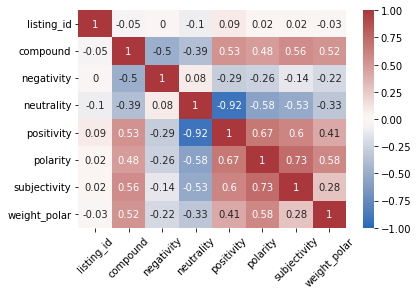

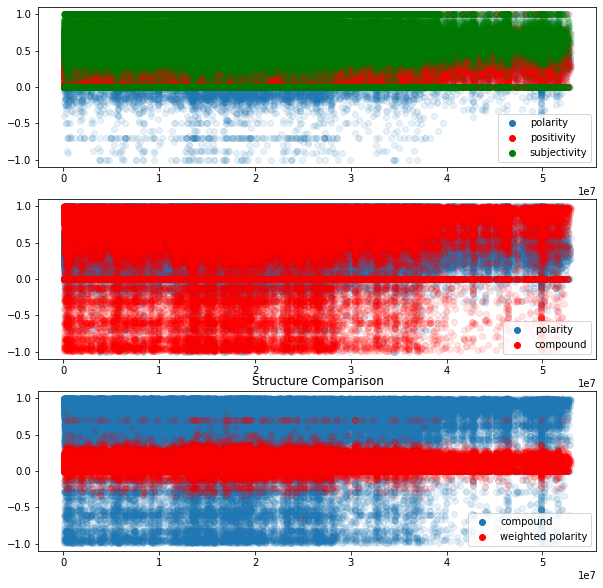

In [21]:
corr_mat = scored_reviews.corr().round(2)
g = sns.heatmap(corr_mat, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment ="center")
plt.show()

fig, axs = plt.subplots(3, figsize=(10,10))
plt.title("Structure Comparison")

axs[0].scatter(scored_reviews['listing_id'], scored_reviews["polarity"], alpha=0.1, label = "polarity")
axs[0].scatter(scored_reviews['listing_id'], scored_reviews["positivity"], c="red",alpha=0.1, label = "positivity")
axs[0].scatter(scored_reviews['listing_id'], -scored_reviews["negativity"], c="green",alpha=0.1, label = "negativity")
leg1 = axs[0].legend(loc = "lower right")
#Disable opacity for legend
for lh in leg1.legendHandles:
    lh.set_alpha(1)

axs[1].scatter(scored_reviews['listing_id'], scored_reviews["polarity"], alpha=0.1, label = "polarity")
axs[1].scatter(scored_reviews['listing_id'], scored_reviews["compound"], c="red",alpha=0.1, label = "compound")
leg2 = axs[1].legend(loc = "lower right")
#Disable opacity for legend
for lh in leg2.legendHandles:
    lh.set_alpha(1)

axs[2].scatter(scored_reviews['listing_id'], scored_reviews["compound"], alpha=0.1, label = "compound")
axs[2].scatter(scored_reviews['listing_id'], scored_reviews["weight_polar"], c="red",alpha=0.1, label = "weighted polarity")
leg2 = axs[2].legend(loc = "lower right")
#Disable opacity for legend
for lh in leg2.legendHandles:
    lh.set_alpha(1)

plt.show()

Also add length of reviews

In [22]:
scored_reviews["review_length"] = scored_reviews["review"].apply(lambda x: len(x))
del scored_reviews["review"]

Group by listing_id to use it sufficiently.

In [23]:
listings_reviews_min = scored_reviews.groupby(["listing_id"]).min()
listings_reviews_max = scored_reviews.groupby(["listing_id"]).max()
listings_reviews_mean = scored_reviews.groupby(["listing_id"]).mean()

extr_col = listings_reviews_min[["negativity", "polarity"]]
extr_col.columns = ["most_negative", "smallest_polarity"]
extr_col["most_positive"] = listings_reviews_max["positivity"]
extr_col["highest_polarity"] = listings_reviews_max["polarity"]
#extr_col = extr_col.insert(0, listings_reviews_min["listing_id"] 0)

listings_reviews = pd.concat([listings_reviews_mean, extr_col], axis=1)
listings_reviews.reset_index(inplace=True)


d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Further Texts
Which are: ["name", "host_name", "description", "neighborhood_overview", "host_about"]
Name - "Name of the listing"
host_name - "Name of the host. Usually just the first name(s)."
description: "Detailed description of the listing"
neighbourhood_overview: "Host's description of the neighbourhood"
host_about: "Description about the host"

All these variables are written by the host (or naturally given, like their name).
Detecting positive or negative sentiments does not make sense.
But it might have an effect how much effort to shine or how much love they put in the
descriptions. So the length shall be enough at this place.

For Name and/or host_name a Neural Network could be something to think about.

In [ ]:
text_col = ["name", "host_name", "description", "neighborhood_overview", "host_about"]

listings["name_length"] = listings["name"].apply(lambda x: len(x))
listings["description_length"] = listings["description"].apply(lambda x: len(x))
listings["neighborhood_overview_length"] = listings["neighborhood_overview"].apply(lambda x: len(x))
listings["host_about_length"] = listings["host_about"].apply(lambda x: len(x))

listings = listings.drop(text_col, axis = 1)

In [ ]:
listings_reviews.columns = ["id", 'compound', 'negativity', 'neutrality', 'positivity',
       'polarity', 'subjectivity', 'weight_polar', 'review_length',
       'most_negative', 'smallest_polarity', 'most_positive',
       'highest_polarity']

listings2 = pd.merge(listings, listings_reviews, how="left")
listings2.fillna(0)